In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 
import keras_cv

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = True
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-04-03 09:42:24.750241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 09:42:26.918766: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-03 09:42:26.918835: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-03 09:42:32.768104: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [2]:
"""
Creating the model
"""
def conv_block(x, n_filt, size_conv=(5,5), n_conv=3):
    """
    Applies n_conv convolutions to the input with specified size and number of filters.
    """
    for c in range(n_conv):
        x = tf.keras.layers.Conv2D(n_filt, size_conv, padding="same", activation=None)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
    return x

def u_encoder(x, n_filt):
    """
    Applies conv_block and returnes max pooled and skip-connection.
    """
    x = conv_block(x, n_filt)
    return tf.keras.layers.MaxPool2D()(x), x

def u_decoder(pooled, skipped, n_filt):
    """
    Upsamples pooled and concats with skiped.
    """
    upsampled = tf.keras.layers.Convolution2DTranspose(n_filt, (2,2), strides=(2,2), padding='same')(pooled)
    return conv_block(tf.keras.layers.concatenate([upsampled, skipped]), n_filt)
    
    
def make_unet(inp, depth=3, output_channels=1):
    skipped = []
    p = inp
    for _ in range(depth):
        p, s = u_encoder(p, 2**(1+_))
        #p, s = u_encoder(p, 2*(1+_))
        skipped.append(s)
    p = conv_block(p, 2**(2+depth))
    for _ in reversed(range(depth)):
        p = u_decoder(p, skipped[_], 2**(2+_))  
        #p = u_decoder(p, skipped[_], (2**3)*(1+_))  
    p = tf.keras.layers.Conv2D(output_channels, (1,1), activation='sigmoid')(p)
    return p

def get_model(inp):
    """
    Takes network Input layer 
    """
    outp = make_unet(inp)
    return tf.keras.models.Model(inp, outp)



In [9]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            if train_var:
                var = np.random.choice([10,20,50])
            else:
                #var = abs(var_u - np.random.exponential(var_d))
                var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            y = tf.image.image_gradients(tf.constant(np.array([y])))
            y = np.sqrt(y[0]**2 + y[1]**2)[0]
            y = y - np.amin(y)
            y = np.clip(y/np.percentile(y,90),0.,1.)

            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [4]:
BATCH_SIZE = 50
train_var = False
var_d=5
var_u=60
pre = False
same = False

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

2023-04-03 09:42:43.623425: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-03 09:42:43.630456: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-03 09:42:43.630554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-04-03 09:42:43.709942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [5]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

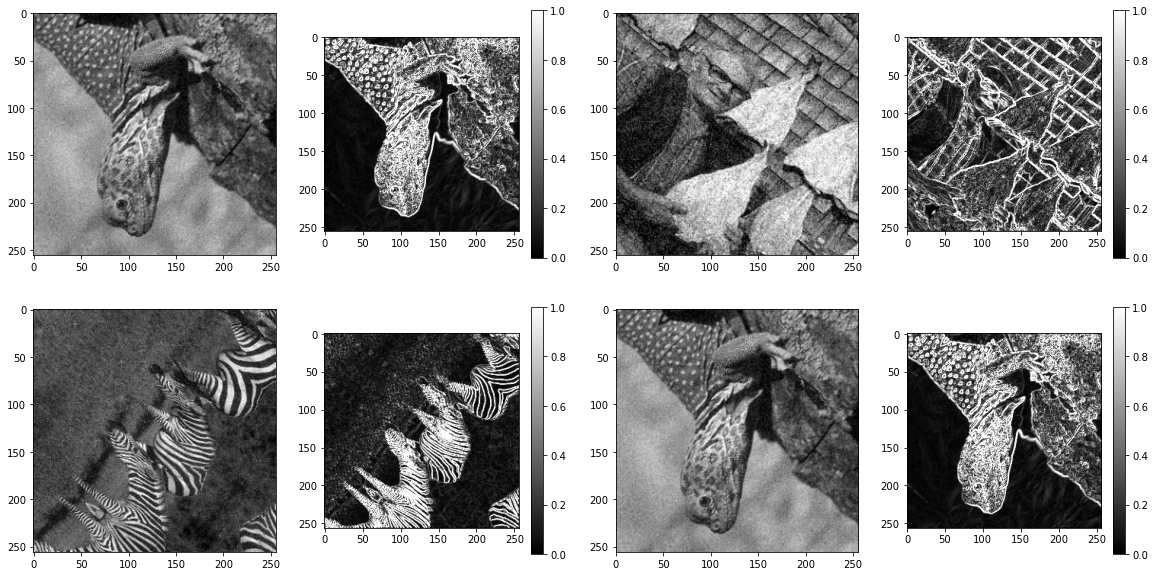

In [6]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        im = axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        plt.colorbar(im,ax=axs[i,2*j+1])
        #axs[i,2*j].set_title(str(np.mean(xs[_])))
        
plt.show()

In [7]:
model= get_model(tf.keras.layers.Input(shape=(CROP,CROP, 1)))
#model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False))
model.compile(optimizer='adam', loss='mse')
#model.load_weights(f"./checkpoints/borders_{typ}")

callbacks = [tf.keras.callbacks.ModelCheckpoint(
            filepath= f"./checkpoints/borders_{typ}",
            save_weights_only=True,
            verbose = True,
            save_best_only=True),
                        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1),
                        tf.keras.callbacks.TerminateOnNaN()

            ]

history = model.fit(
    gen_batch_train,
    epochs=20,
    steps_per_epoch=100,
    validation_data=gen_batch_val,
    validation_steps=10,
    shuffle=False,
    use_multiprocessing=True,
    callbacks=callbacks,
    workers=1
)

Epoch 1/20


2023-03-28 19:00:40.058089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-28 19:00:41.532878: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55a428ee1be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 19:00:41.532898: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2023-03-28 19:00:41.532902: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA RTX A5000, Compute Capability 8.6
2023-03-28 19:00:41.536508: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 19:00:41.630623: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - ETA: 0s - loss: 0.0936
Epoch 1: val_loss improved from inf to 0.10369, saving model to ./checkpoints/borders_gaussian
100/100 [==============================] - 80s 695ms/step - loss: 0.0936 - val_loss: 0.1037 - lr: 0.0010
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.0824
Epoch 2: val_loss improved from 0.10369 to 0.09476, saving model to ./checkpoints/borders_gaussian
100/100 [==============================] - 67s 679ms/step - loss: 0.0824 - val_loss: 0.0948 - lr: 0.0010
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0761
Epoch 3: val_loss improved from 0.09476 to 0.09307, saving model to ./checkpoints/borders_gaussian
100/100 [==============================] - 69s 696ms/step - loss: 0.0761 - val_loss: 0.0931 - lr: 0.0010
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.0722
Epoch 4: val_loss improved from 0.09307 to 0.07786, saving model to ./checkpoints/borders_gauss

In [7]:
model= get_model(tf.keras.layers.Input(shape=(CROP,CROP, 1)))
model.load_weights(f"./checkpoints/borders_{typ}")

In [8]:
xs, ys = next(gen_batch_val.as_numpy_iterator())
pr = model(xs)

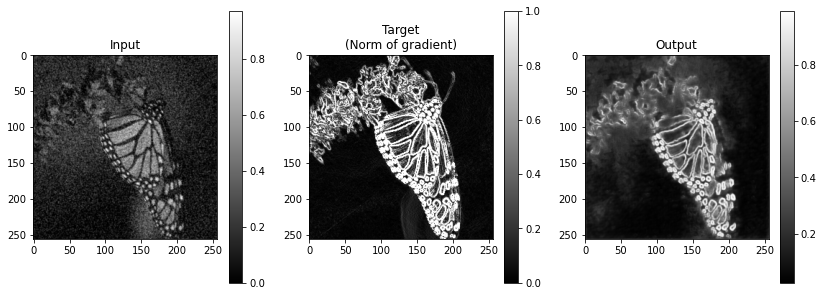

In [13]:
_ = np.random.choice(BATCH_SIZE)
plt.figure(figsize=(14,5))
plt.subplot(131), plt.imshow(xs[_, ..., 0],cmap='gray'), plt.colorbar()
plt.title('Input')
plt.subplot(132), plt.imshow(ys[_],cmap='gray'), plt.colorbar()
plt.title('Target\n(Norm of gradient)')
plt.subplot(133), plt.imshow(pr[_,...,0],cmap='gray'), plt.colorbar()
plt.title('Output')
plt.show()

# Comparison

In [13]:
model= get_model(tf.keras.layers.Input(shape=(CROP,CROP, 1)))
model.load_weights(f"./checkpoints/borders_{typ}")

In [10]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            if train_var:
                var = np.random.choice([10,20,50])
            else:
                #var = abs(var_u - np.random.exponential(var_d))
                var = np.random.uniform(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            z = np.copy(y)
            y = tf.image.image_gradients(tf.constant(np.array([y])))
            y = np.sqrt(y[0]**2 + y[1]**2)[0]
            y = y - np.amin(y)
            y = np.clip(y/np.percentile(y,90),0.,1.)

            yield x,y,z
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [81]:
BATCH_SIZE = 50
train_var = False
var_d=5
var_u=60
pre = False
same = False


def make_generators(BATCH_SIZE,var_d,var_u):
    dg_train = tf.data.Dataset.from_generator(
        get_data_generator(sample_images(train)),
        output_types=(tf.float32, tf.float32,tf.float32),
        output_shapes=((CROP, CROP, 1),(CROP, CROP, 1),(CROP, CROP, 1)) )

    dg_val = tf.data.Dataset.from_generator(
        get_data_generator(sample_images(test)),
        output_types=(tf.float32, tf.float32,tf.float32),
        output_shapes=((CROP, CROP, 1),(CROP, CROP, 1),(CROP, CROP, 1)) )
    
    return dg_train.batch(BATCH_SIZE), dg_val.batch(BATCH_SIZE)

gen_batch_train, gen_batch_val = make_generators(BATCH_SIZE,var_d,var_u)

In [91]:
xs, ys, zs = next(gen_batch_val.as_numpy_iterator())
grad_model = model(xs)
dx,dy = tf.image.image_gradients(tf.constant(xs))
grad = np.sqrt(dx**2+dy**2)
dx0,dy0 = tf.image.image_gradients(tf.constant(zs))
grad0 = np.sqrt(dx0**2+dy0**2)


grad += -np.amin(grad,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
grad = grad/np.amax(grad,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))

grad0 += -np.amin(grad0,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
grad0 = grad0/np.amax(grad0,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))

grad_model += -np.amin(grad_model,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
grad_model = grad_model/np.amax(grad_model,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))

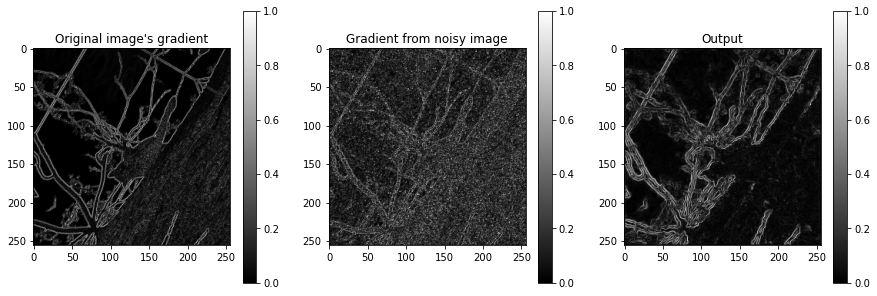

In [98]:
_ = np.random.choice(BATCH_SIZE)
plt.figure(figsize=(15,5))
plt.subplot(132), plt.imshow(grad[_, ..., 0],cmap='gray'), plt.colorbar()
plt.title('Gradient from noisy image')
plt.subplot(131), plt.imshow(grad0[_],cmap='gray'), plt.colorbar()
plt.title("Original image's gradient")
plt.subplot(133), plt.imshow(grad_model[_,...,0],cmap='gray'), plt.colorbar()
plt.title('Output')
plt.show()

In [93]:
l2_model,l2_grad = [],[]

for var_d in tqdm(np.arange(5,65,5)):
    gen_batch_train, gen_batch_val = make_generators(BATCH_SIZE,var_d,var_d)
    
    l2_model_it,l2_grad_it = [],[]
    
    for _ in range(5):
        xs, ys, zs = next(gen_batch_val.as_numpy_iterator())
        pr = model(xs)
        dx,dy = tf.image.image_gradients(tf.constant(xs))
        grad = np.sqrt(dx**2+dy**2)

        dx0,dy0 = tf.image.image_gradients(tf.constant(zs))
        grad0 = np.sqrt(dx0**2+dy0**2)
        
        dx_model,dy_model = tf.image.image_gradients(pr)
        grad_model = np.sqrt(dx_model**2+dy_model**2)
        
        
        grad += -np.amin(grad,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
        grad = grad/np.amax(grad,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))

        grad0 += -np.amin(grad0,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
        grad0 = grad0/np.amax(grad0,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))

        grad_model += -np.amin(grad_model,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))
        grad_model = grad_model/np.amax(grad_model,axis=(1,2,3)).reshape((BATCH_SIZE,1,1,1))


        l2_grad_it.append(np.sqrt(np.sum((grad-grad0)**2,axis=(1,2,3))))
        l2_model_it.append(np.sqrt(np.sum((grad_model-grad0)**2,axis=(1,2,3))))
        
    l2_model.append([np.mean(l2_model_it),np.std(l2_model_it)])
    l2_grad.append([np.mean(l2_grad_it),np.std(l2_grad_it)])
    
l2_model = np.array(l2_model)
l2_grad = np.array(l2_grad)

100%|███████████████████████████████████████████| 12/12 [02:31<00:00, 12.60s/it]


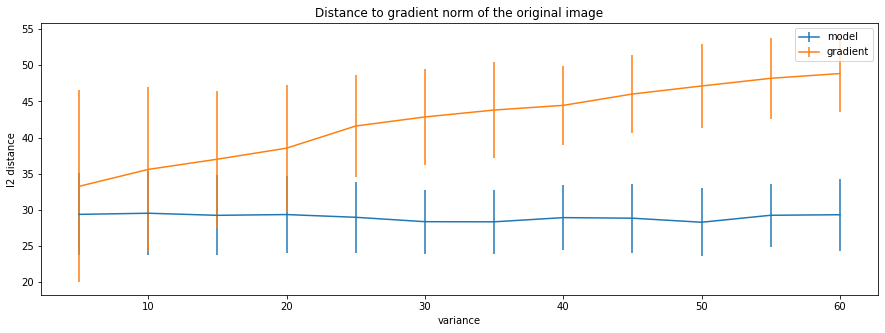

In [97]:
plt.figure(figsize=(15,5))
plt.errorbar(np.arange(5,65,5),l2_model[:,0],l2_model[:,1],label='model')
plt.errorbar(np.arange(5,65,5),l2_grad[:,0],l2_grad[:,1],label='gradient')
plt.xlabel('variance')
plt.ylabel('l2 distance')
plt.title('Distance to gradient norm of the original image')
plt.legend()
plt.show()